In [21]:
from noise_generator import generate_noise_trajectory, monte_carlo_noise
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import *
import scqubits

In [45]:
# Set parameters
sample_rate = 1                    # per ns
t_max = 1e4                          # in ns
relative_PSD_strength = (1e-3)**2    # sets frequency noise PSD at zero frequency, in (ns^-2)/sample_rate
f0 = 1e-4                            # sets cut-off for low-pass filtered noise, in ns^-1
num_realizations = 1000           # Number of Monte-Carlo trajectories


# Try white noise
t_list, trajectories_list, freq_list, white_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0, white=True)

white_noise_psd = np.mean(white_noise_psds, axis=0)

# Try 1/f noise
tlist, trajectories_list, freq_list, lowfreq_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0=f0, white=False)

lowfreq_noise_psd = np.mean(lowfreq_noise_psds, axis=0)

print('Checking definitions: ')
print('Median PSD/ (Defined noise strength * t_max): '+str(np.median(white_noise_psd)/(relative_PSD_strength * t_max)))
print('Std dev of frequency shifts / Square-root of (noise strength * t_max): '+str( (np.std(trajectories_list, axis=0)[-1]) / (np.sqrt(relative_PSD_strength * t_max)) ))

Checking definitions: 
Median PSD/ (Defined noise strength * t_max): 0.9999115396177222
Std dev of frequency shifts / Square-root of (noise strength * t_max): 0.9819549151223624


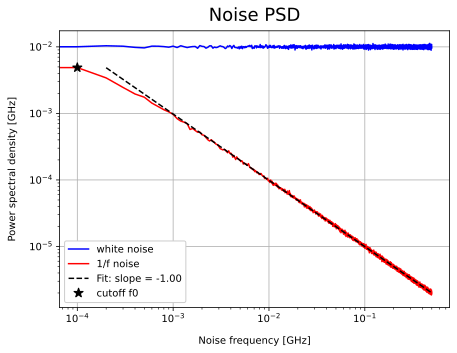

Slope: -0.996
Intercept: -5.998
R-squared: 0.999


In [48]:
import numpy as np
from scipy import stats

# Convert to log space and filter for f > f0
mask = freq_list > f0
log_freq = np.log10(freq_list[mask])
log_psd = np.log10(lowfreq_noise_psd[mask])

# Linear fit in log space
slope, intercept, r_value, p_value, std_err = stats.linregress(log_freq, log_psd)

# Plot
plt.figure(figsize=(7, 5))
plt.title('Noise PSD', pad=10, size=18)
plt.loglog(freq_list, white_noise_psd, 'b', label="white noise")
plt.loglog(freq_list, lowfreq_noise_psd, 'r', label="1/f noise")

# Add fit line (only for f > f0)
fit_freq = freq_list[mask]
fit_psd = 10**(slope * np.log10(fit_freq) + intercept)
plt.loglog(fit_freq, fit_psd, 'k--', label=f'Fit: slope = {slope:.2f}')

plt.plot(f0, lowfreq_noise_psd[np.abs(freq_list - f0).argmin()], 'k*', markersize=10, label='cutoff f0')
# plt.axhline(y = lowfreq_noise_psd[0]/2, color='black', linestyle='dashed', label="3dB in Power")
plt.ylabel(r"Power spectral density [GHz]", labelpad=12)
plt.xlabel("Noise frequency [GHz]", labelpad=12)
plt.legend(framealpha=1.0)
plt.grid()
plt.show()

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")

In [1]:
from scipy.optimize import golden
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-6
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        self.get_projectors()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)

        
    def get_indices(self, dims):
        """
        Convert a list of 2D indices to 1D indices based on given dimensions.
        
        Args:
            dims: List of two integers [N,K] specifying the dimensions to include
                 N is number of cavity states
                 K is number of SNAIL states
                 
        Returns:
            List of 1D indices corresponding to the 2D indices
        """
        N, K = dims
        indices_2d = []
        indices_1d = []
        
        # Generate all 2D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.cdim):
                # Only add indices that are outside the truncation
                if n >= N or k >= K:
                    indices_2d.append(f"{n}{k}")
                    # Convert to 1D index using n*cdim + k
                    idx = n*self.cdim + k
                    indices_1d.append(idx)

        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, np.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        result = matrix.copy()
        for idx in indices:
            result = np.delete(np.delete(result, idx, axis=0), idx, axis=1)
            
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()
        self.U1 = U
        self.Ud1 = Ud

        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control

        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmaxc = np.kron(np.eye(self.sdim), cavity_sigmax)
        self.sigmaxc = self.truncate_matrix(sigmaxc, self.trunc)
        squid_sigmax = np.zeros((self.sdim, self.sdim))
        squid_sigmax[0,1] = 1
        squid_sigmax[1,0] = 1
        sigmaxs = np.kron(squid_sigmax, np.eye(self.cdim))
        self.sigmaxs = self.truncate_matrix(sigmaxs, self.trunc)
    
    
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()

        self.H_per = H
        self.H_control_per = H_control

        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]

    def get_noise_operator(self):
        H_per = self.H_per
        H = self.H
        self.noise = (H_per - H) / self.epsilon
        
        # s = self.annihilation(self.sdim)
        # sd = self.creation(self.sdim)
        # ic = np.identity(self.cdim)
        # self.noise = self.truncate_matrix(np.kron(sd@s, ic), self.trunc)

        self.noise = self.Ud1@self.noise@self.U1
        
        self.noise = self.truncate_matrix(self.noise, self.trunc)
        self.H = self.Ud1@self.H@self.U1
        self.H = self.truncate_matrix(self.H, self.trunc)
        self.H_control = self.Ud1@self.H_control@self.U1
        self.H_control = self.truncate_matrix(self.H_control, self.trunc)
    
    def get_projectors(self):
        trunc = self.trunc
        truncated_total_dim = trunc[-1]*trunc[-2]
        projectors = []
        for i in range(truncated_total_dim):
            projector = qt.basis(truncated_total_dim, i)*qt.basis(truncated_total_dim, i).dag()

            projectors.append(projector)
        self.projectors = projectors
        

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        return self.static_rate(der1)

    
    def optimal_omegad(self, A):
        # Create a wrapper function that ensures we return a Python float
        def calculate_dr_wrapper(A, omega_d):
            result = self.calculate_dr_exact(A, omega_d)
            return float(result)

        # Define objective function
        def objective(omega_d):
            return calculate_dr_wrapper(A, omega_d)

        # Try different bracketing values until we find ones that work
        omega_min = 5.8 * 2 * np.pi
        omega_max = 6.4 * 2 * np.pi
        n_points = 10
        omega_range = np.linspace(omega_min, omega_max, n_points)
        
        # Find minimum point among test points
        rates = [objective(omega) for omega in omega_range]
        min_idx = np.argmin(rates)
        
        if min_idx == 0 or min_idx == len(omega_range)-1:
            # If minimum is at edge, return that value
            optimal_omega = omega_range[min_idx]
            min_rate = rates[min_idx]
        else:
            # Use points around minimum for bracketing
            xa = omega_range[min_idx-1]
            xb = omega_range[min_idx]
            xc = omega_range[min_idx+1]
            
            # Use golden section search for optimization
            optimal_omega = golden(objective, brack=(xa, xb, xc))
            min_rate = objective(optimal_omega)
        
        return optimal_omega/2/np.pi, min_rate
    

    def calculate_floquet_U(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        self.sigmax_dressed = Ud@self.sigmaxc@U
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        return initial_state, self.sigmax_dressed,
    
    def calculate_floquet_U_test(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        noise = Ud@self.noise@U
        H = Ud@self.H@U
        H_control = Ud@self.H_control@U
        return noise, H, H_control

    def H_approximation(self, A, omega,):
        self.get_H()
        s = self.annihilation(self.sdim)
        sd = self.creation(self.sdim)
        c = self.annihilation(self.cdim)
        cd = self.creation(self.cdim)
        Is = np.eye(self.sdim)
        Ic = np.eye(self.cdim)
        H = (self.omega_s - omega)* np.kron(sd@s,Ic) + self.anh/2 *np.kron(sd@sd@s@s,Ic) + self.omega_c*np.kron(Is,cd@c) 
        +self.chi*np.kron(sd@s,cd@c) 
        H = self.remove_row_col(H)
        Hc =  A/2/2/self.phi_zpf*(np.kron(s+sd,Ic))
        Hc = self.remove_row_col(Hc)
        return H,Hc

In [4]:
import numpy as np

def zero_first_two_rows_cols(matrix, idx):
    """
    Set the first two rows and first two columns of a given matrix to zero.
    
    Args:
        matrix (numpy.ndarray): Input matrix.
        
    Returns:
        numpy.ndarray: Matrix with the first two rows and first two columns set to zero.
    """
    new_matrix = matrix.copy()
    new_matrix[:idx, :] = 0
    new_matrix[:, :idx] = 0
    return new_matrix


In [5]:
from joblib import Parallel, delayed


def _single_trajectory(idx, sample_rate, t_max, relative_PSD_strength, f0, white, H0, init_state, H_control, A, optimal_omega, noise,ex_ops):
    t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
    args = {'w': optimal_omega}
    noise_op = qt.Qobj(noise)
    H_tot = [H0, [noise_op, shifts]]
    options = {'nsteps': 100000, 'atol': 1e-13, 'rtol': 1e-13}  # Increase nsteps to handle the integration
    result = qt.sesolve(H_tot, init_state, t_list, e_ops=ex_ops, args=args, options = options)
    return shifts, result.expect, psd, t_list, freq_list

def monte_carlo_squid(H0, init_state, H_control, A, optimal_omega, noise,
                     detuning=0.0, num_realizations=1000, sample_rate=1, t_max=200, 
                     relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, ex_ops=None, n_jobs=60):
    N = int(sample_rate*t_max) + 1
    trajectories_list = np.zeros((num_realizations, N))
    
    # Sequential computation for debugging
    # results = []
    # for idx in range(num_realizations):
    #     result = _single_trajectory(
    #         idx, sample_rate, t_max, relative_PSD_strength, f0, white,
    #         H0, init_state, sigmax, H_control, A, optimal_omega, noise
    #     )
    #     results.append(result)
        
    # Parallel computation for performance
    results = Parallel(n_jobs=n_jobs)(
        delayed(_single_trajectory)(
            idx, sample_rate, t_max, relative_PSD_strength, f0, white,
            H0, init_state, H_control, A, optimal_omega, noise, ex_ops
        ) for idx in range(num_realizations)
    )
    
    # Unpack results
    # Get shape of expectation values from first result
    expect_shape = np.array(results[0][1]).shape
    Xtraj_list = np.zeros((num_realizations,) + expect_shape)
    noise_psd = np.zeros(N//2)
    
    for idx, (shifts, expect, psd, t_list, freq_list) in enumerate(results):
        trajectories_list[idx] = shifts
        Xtraj_list[idx] = np.array(expect)
        noise_psd += psd
    
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

undriven, squid dephasing ramsey

In [6]:
# Set parameters
sample_rate = 1                      # per us
t_max = 200                          # in us
relative_PSD_strength = (2e-2)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 20           # Number of Monte-Carlo trajectories

phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 3)).unit()
sigmax = qt.Qobj(sc.sigmaxs)
A = 0.
omega = 10*2*np.pi
noise = sc.noise
projectors = sc.projectors
# Combine existing projectors and sigmax into single list
ex_ops = [*projectors, sigmax]



# A = 1e-3 * 2 * np.pi
# optimal_omega, min_rate = sc.optimal_omegad(A)

In [80]:
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_squid(H0, init_state, sigmax, H_control, A, omega, noise, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 6.16 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, mean_Xtraj_lowfreq, p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, mean_Xtraj_lowfreq, label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

KeyboardInterrupt: 

undrive cavity

In [20]:
# Set parameters
sample_rate = 1                      # per us
t_max = 200                          # in us
relative_PSD_strength = (12e-2)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 20           # Number of Monte-Carlo trajectories


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 1)).unit()
sigmax = qt.Qobj(sc.sigmaxc)
A = 0.
omega = 10*2*np.pi
noise = sc.noise
# noise = zero_first_two_rows_cols(noise, 2)
projectors = sc.projectors
# Combine existing projectors and sigmax into single list
ex_ops = [*projectors, sigmax]
# noise = zero_first_two_rows_cols(noise, 4)
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_squid(H0, init_state, H_control, A, omega, noise, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False, ex_ops=ex_ops)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)


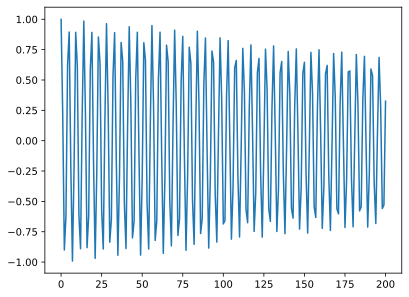

In [21]:
plt.plot(np.mean(Xtraj_list_lowfreq, axis=0)[-1])

Fitted gamma: 0.0017286477601091243
Fitted w: 32.7605761643793


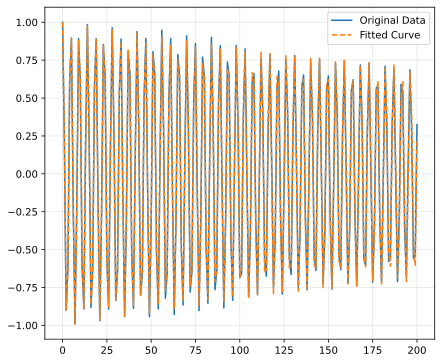

In [22]:
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 5.2 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, np.mean(Xtraj_list_lowfreq, axis=0)[-1], p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, np.mean(Xtraj_list_lowfreq, axis=0)[-1], label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [99]:
import numpy as np

def zero_first_two_rows_cols(matrix, idx):
    """
    Set the first two rows and first two columns of a given matrix to zero.
    
    Args:
        matrix (numpy.ndarray): Input matrix.
        
    Returns:
        numpy.ndarray: Matrix with the first two rows and first two columns set to zero.
    """
    new_matrix = matrix.copy()
    new_matrix[:idx, :] = 0
    new_matrix[:, :idx] = 0
    return new_matrix



In [108]:
sc.noise

array([[ 2.83017001e-03-3.68735400e-30j, -5.66805964e-10+1.32996544e-10j,
        -2.58804753e-06+8.28881467e-21j, -5.57212460e-09-1.29462490e-11j,
         2.96647331e-02+5.29869165e-21j, -1.30879673e-10-8.62999176e-13j,
        -3.54924690e-04+1.07303891e-20j, -4.29909527e-10+7.45645446e-14j,
        -2.95219848e-03-1.03113680e-17j, -1.05882288e-09+1.19660897e-14j,
        -8.90700818e-03-9.25554054e-18j,  4.10999044e-10-6.14065286e-15j,
         2.63725119e-03-1.14462191e-17j,  7.93766253e-10+3.41752315e-16j,
         1.87917602e-04+6.59002833e-19j],
       [ 1.40051273e-11+3.28619614e-12j, -4.08820192e-01+4.63647983e-18j,
         7.84407385e-10+1.84055699e-10j, -4.18973960e+00-9.93365316e-01j,
        -5.16720929e-09-1.21244999e-09j,  4.10372758e-02+9.91500665e-03j,
         1.56520386e-09+3.67262549e-10j,  2.00944220e-03+4.71132067e-04j,
        -1.02852115e-09-2.41332421e-10j, -1.37033311e-02-3.21521515e-03j,
        -1.57217979e-09-3.68901512e-10j, -1.21478971e-02-2.85021672e-0

Fitted gamma: 0.00039636466736721977
Fitted w: 32.762453234078315


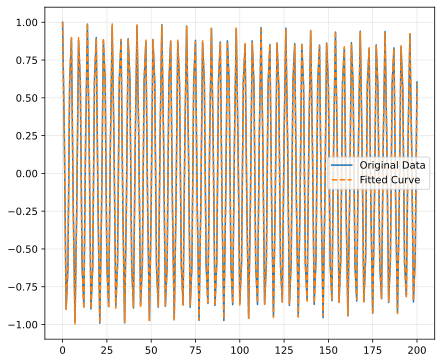

In [100]:
noise = sc.noise.copy()
noise[3,3] = 0
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_squid(H0, init_state, sigmax, H_control, A, omega, noise, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 5.2 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, mean_Xtraj_lowfreq, p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, mean_Xtraj_lowfreq, label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Fitted gamma: 0.0051570450404039014
Fitted w: 32.76004981508103


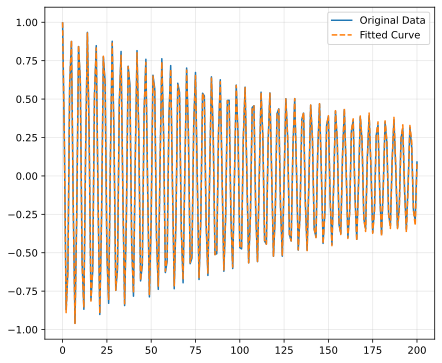

In [34]:
phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 1e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi
initial_state, sigmax = sc.calculate_floquet_U(A, optimal_omega)
initial_state = qt.Qobj(initial_state)
sigmax = qt.Qobj(sigmax)
noise = sc.noise


t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_squid(H0, init_state, sigmax, H_control, A, omega, noise, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 5.2 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, mean_Xtraj_lowfreq, p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, mean_Xtraj_lowfreq, label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [95]:
sc.optimal_omegad(A)[0]*2*np.pi

38.73839655620458

In [35]:
from joblib import Parallel, delayed

def _single_trajectory(idx, sample_rate, t_max, relative_PSD_strength, f0, white, H0, init_state, sigmax, sc, H_control, A, optimal_omega):
    t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
    args = {'w': optimal_omega}
    noise_op = qt.Qobj(sc.noise)
    H_tot = [H0, [noise_op, shifts], [H_control, lambda t, args: A * np.cos(args['w'] * t)]]
    result = qt.sesolve(H_tot, init_state, t_list, e_ops=[sigmax], args=args)
    return shifts, result.expect[0], psd, t_list, freq_list

def monte_carlo_squid(detuning=0.0, num_realizations=1000, sample_rate=1, t_max=200, 
                     relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, n_jobs=50):
    N = int(sample_rate*t_max) + 1
    trajectories_list = np.zeros((num_realizations, N))
    
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
    H0 = qt.Qobj(sc.H)
    H_control = qt.Qobj(sc.H_control)
    A = 1e-3 * 2 * np.pi
    optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi
    initial_state, sigmax = sc.calculate_floquet_U(A, optimal_omega)
    initial_state = qt.Qobj(initial_state)
    sigmax = qt.Qobj(sigmax)
    # Parallel computation of trajectories
    results = Parallel(n_jobs=n_jobs)(
        delayed(_single_trajectory)(
            idx, sample_rate, t_max, relative_PSD_strength, f0, white,
            H0, initial_state, sigmax, sc, H_control, A, optimal_omega
        ) for idx in range(num_realizations)
    )
    
    # Unpack results
    Xtraj_list = np.zeros((num_realizations, N))
    noise_psd = np.zeros(N//2)
    
    for idx, (shifts, expect, psd, t_list, freq_list) in enumerate(results):
        trajectories_list[idx] = shifts
        Xtraj_list[idx] = expect
        noise_psd += psd
    
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

In [36]:
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_squid(detuning=0, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)


Fitted gamma: 0.005362735614021674
Fitted w: 32.75962261423937


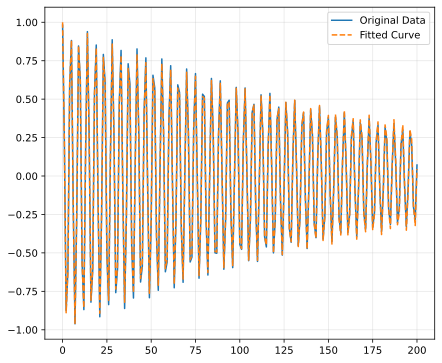

In [37]:
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 5.2 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, mean_Xtraj_lowfreq, p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, mean_Xtraj_lowfreq, label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()